In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import time
# from sklearn.externals import joblib
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score
import warnings
import torch.nn as nn
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
train = data[(data['data_date'] >= '2019-12-02')
             & (data['data_date'] <= '2021-07-22')
             & (data.asin == 'B07QHSZGXC')].copy()[['data_date',  'ordered_units']].sort_values('data_date')

In [4]:
test = data[(data['data_date'] >= '2021-07-23')
            & (data['data_date'] <= '2021-08-22')
            & (data.asin == 'B07QHSZGXC')].copy()[['data_date', 'ordered_units']].sort_values('data_date')

In [5]:
train.head(2).append(train.tail(2))

,data_date,ordered_units
15974,2019-12-02,1034
15937,2019-12-03,193
26926,2021-07-21,160
27288,2021-07-22,171


## ordered_units

In [37]:
from scipy.stats import norm

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(train.data_date, train.ordered_units)

AttributeError: 'DataFrame' object has no attribute 'data_date'

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

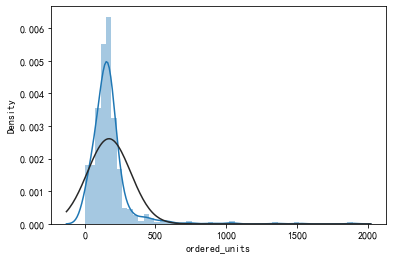

In [17]:
sns.distplot(train.ordered_units, kde=True, fit=norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [6]:
train.drop(train[train.ordered_units <= 0].index, inplace=True)

In [8]:
train.drop(train[train.ordered_units > 1000].index, inplace=True)

In [10]:
train.shape, test.shape

((581, 2), (31, 2))

### 设置样本权重

In [11]:
weight = train.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

### 缺失值

In [12]:
train.isnull().sum()

data_date        0
ordered_units    0
dtype: int64

无缺失值不用处理

### 创造特征

In [13]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday

    df.drop('data_date', axis=1, inplace=True)
    return df

In [14]:
train = create_feature(train)

In [15]:
train.head(3)

,ordered_units,year,month,day,weekday
15937,193,2019,12,3,1
15902,212,2019,12,4,2
15869,211,2019,12,5,3


In [16]:
x_train = train.drop('ordered_units', axis=1)
y_train = train['ordered_units']

In [17]:
train.shape

(581, 5)

<AxesSubplot:xlabel='year', ylabel='ordered_units'>

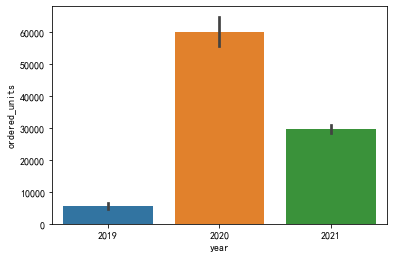

In [41]:
sns.barplot('year', 'ordered_units', data=train, estimator=np.sum)

<AxesSubplot:xlabel='day', ylabel='ordered_units'>

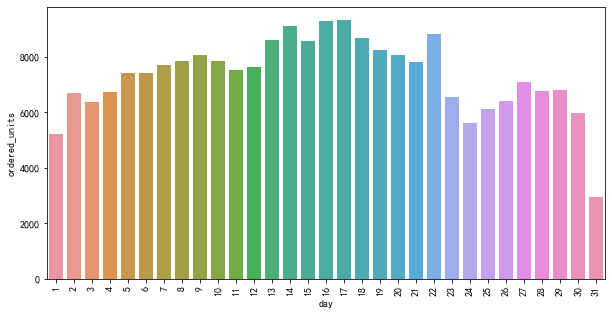

In [28]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot('day', 'ordered_units', data=train, ci=0, estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='ordered_units'>

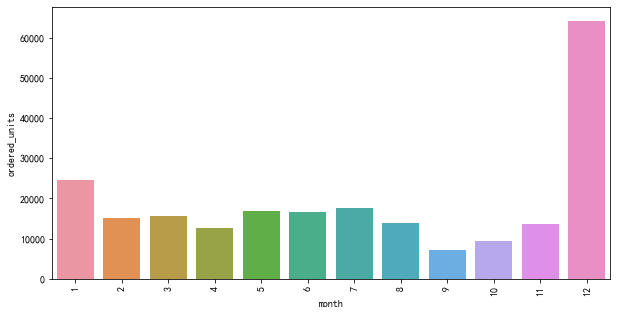

In [29]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot('month', 'ordered_units', data=train, ci=0, estimator=np.sum)

### 编码

In [18]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_train.shape

(581, 53)

## 数据转换

In [22]:
train.ordered_units = np.log1p(train.ordered_units)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

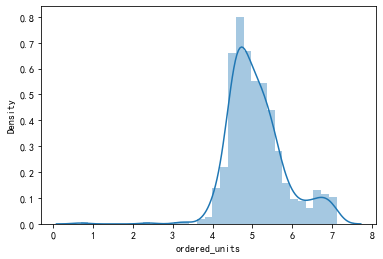

In [23]:
sns.distplot(train.ordered_units)

## 训练

In [19]:
dtrain = xgb.DMatrix(x_train, y_train, weight=weight)

In [22]:
ts = time.time()
params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 4,
          'subsample': 0.8,
          'colsample_bytree': 1,
          #           'min_child_weight': 15,
          'n_jobs': 8}
model = xgb.train(params, dtrain, 1500)
print('running time: {:.3f}'.format(time.time() - ts))

running time: 0.787


In [23]:
result_cv = xgb.cv(params, dtrain, num_boost_round=1500)
result_cv.mean(0)

train-rmse-mean    3.2245
train-rmse-std     0.2417
test-rmse-mean    90.1047
test-rmse-std     15.7464
dtype: float64

In [44]:
gain = model.get_score(importance_type='gain')

In [54]:
# 排序
dict(sorted(gain.items(), key=lambda x: x[1], reverse=True))

{'f14': 4753614.206700143,
 'f12': 2536611.11103155,
 'f28': 1845820.2873747721,
 'f41': 968826.983091649,
 'f43': 933737.7838294341,
 'f13': 930441.32557372,
 'f38': 657623.4768817095,
 'f27': 651218.9222940371,
 'f39': 607281.3824630274,
 'f19': 540033.3325127403,
 'f37': 468928.60717144783,
 'f45': 436923.85375754413,
 'f17': 430803.0099144,
 'f18': 378455.7411326662,
 'f36': 353710.7436862252,
 'f40': 335894.9102953424,
 'f15': 331995.2757055482,
 'f21': 321755.51548837364,
 'f52': 309870.65113898425,
 'f51': 275501.7296918421,
 'f9': 272045.6429956756,
 'f44': 263599.20155918755,
 'f6': 254375.83356799211,
 'f30': 246950.17880419345,
 'f1': 242052.09330111608,
 'f3': 239270.28921398998,
 'f42': 238771.29306659996,
 'f16': 229990.62657775157,
 'f50': 222705.8182869593,
 'f0': 208870.20697933095,
 'f10': 203948.4855520733,
 'f2': 203221.55248863308,
 'f7': 197069.43710691785,
 'f46': 180323.21037528885,
 'f48': 164939.50993861756,
 'f20': 154607.54095833335,
 'f8': 153066.7993783411

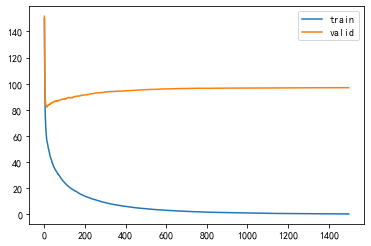

In [52]:
plt.plot(result_cv.iloc[:, 0], label='train')
plt.plot(result_cv.iloc[:, 2], label='valid')
plt.legend()

## 评判标准

- 分开
- 添加特征，weekday
- 赋予权重

In [24]:
def metrics1(y_true, y_pred):
    return 1 - (abs(y_true.sum() - y_pred.sum()) / y_true.sum())

def metrics2(y_true, y_pred):
    return 1 - (abs(y_true - y_pred) / y_true).mean()

## 测试：B07QHSZGXC, 炸锅配件

In [25]:
test = create_feature(test)

In [26]:
x_test = test.drop('ordered_units', axis=1)
y_test = test['ordered_units']

In [27]:
x_test = encoder.transform(x_test)
dtest = xgb.DMatrix(x_test, y_test)
y_pred = model.predict(dtest)

In [29]:
metrics1(y_test, y_pred), metrics2(y_test, y_pred)

(0.7370639826288287, 0.6746703578760311)

In [36]:
r2_score(y_test, y_pred)

-5.732597207673865

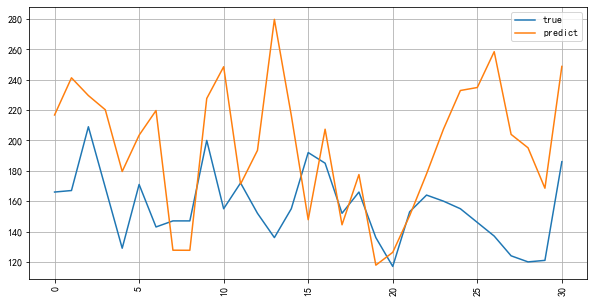

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [34]:
model.get_score(importance_type='gain')

{'f14': 3042374.985088729,
 'f13': 358552.22824106197,
 'f9': 146128.25251596505,
 'f3': 111941.48236222386,
 'f1': 141058.80281622673,
 'f43': 609323.5676659085,
 'f41': 602215.9661931449,
 'f19': 383119.6733306013,
 'f38': 394170.31961288635,
 'f21': 317426.0757999542,
 'f0': 79237.06850256861,
 'f52': 151573.4298110078,
 'f28': 379308.6636732541,
 'f12': 2013569.940090691,
 'f36': 214379.11563564083,
 'f5': 110610.99444934884,
 'f18': 252689.29540129338,
 'f10': 98289.70967356893,
 'f45': 438553.81571216875,
 'f37': 330657.5008224581,
 'f39': 490125.1891993121,
 'f27': 213684.5978406605,
 'f15': 130180.633307367,
 'f16': 152423.3561790141,
 'f30': 84133.76283876522,
 'f31': 62333.55397364114,
 'f7': 87670.06055189196,
 'f6': 59112.96962543006,
 'f44': 149815.55507578218,
 'f48': 92440.31944110402,
 'f23': 108752.34458479924,
 'f2': 78249.36374611317,
 'f50': 51522.43130134204,
 'f40': 242900.81409711772,
 'f51': 87848.98291322895,
 'f22': 77716.84174696743,
 'f11': 73315.01041049376

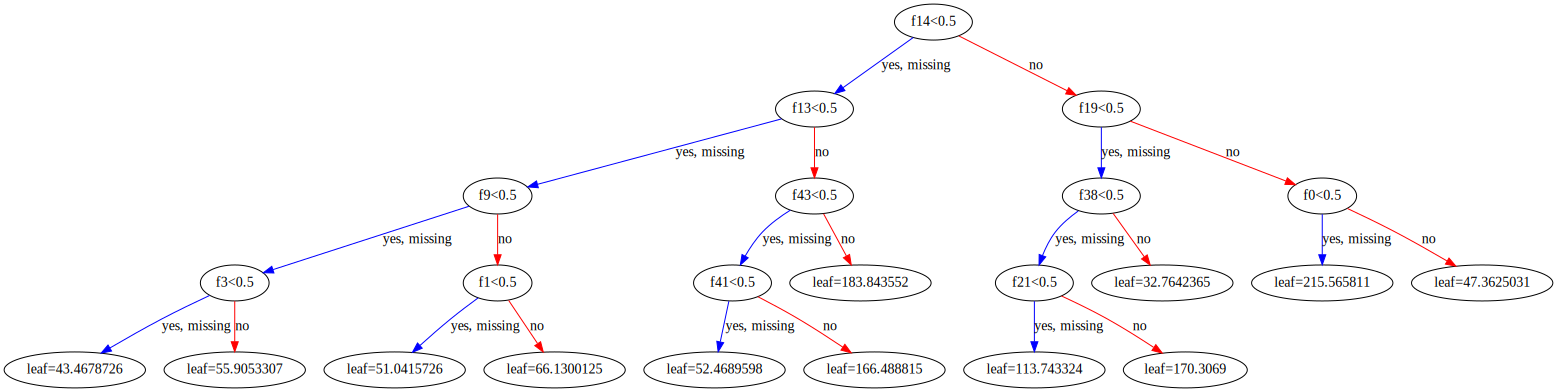

In [35]:
xgb.to_graphviz(model, num_trees=0)

[10:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.00959796, 0.01645038, 0.67658573, 0.29736587], dtype=float32)

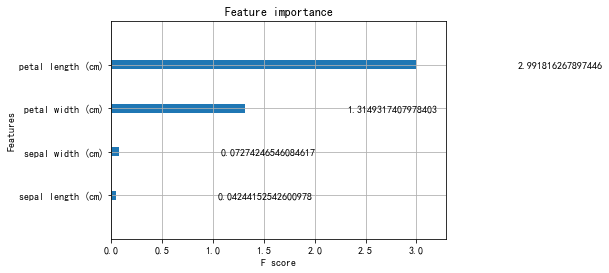

In [71]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [69]:
model.feature_importances_.sum()

1.0

In [73]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

0.6766022886607264

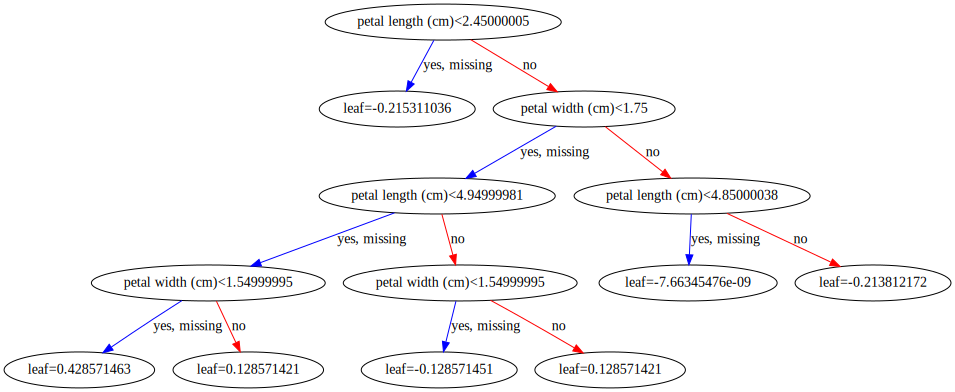

In [75]:
xgb.to_graphviz(model, num_trees=1)

In [77]:
from sklearn.tree import DecisionTreeClassifier

In [109]:
dt = DecisionTreeClassifier(max_depth=2)

In [110]:
dt.fit(x, y)

DecisionTreeClassifier(max_depth=2)

In [111]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [112]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

array([0.        , 0.        , 0.56199095, 0.43800905])

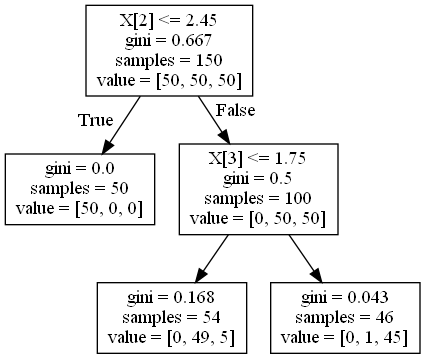

In [113]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())